# Modeling: Random Forest & XGB

Using random forest models to predict cvd risk for demographic features, then using ensemble methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
#importing dataset with demographic data 
df = pd.read_csv('~/Downloads/capstone/CapstoneJulyNYC/Data/Clean_Data/final_data.csv')
df.set_index('SEQN',inplace=True)
df

,sex,age,fam_income_poverty_ratio,Education_College graduate or above,Education_Don't Know,Education_High school graduate/GED or equivalent,Education_Less than 9th grade,Education_Refused,Education_Some college or AA degree,Marital_Status_Married,...,heart_attack_No,heart_attack_Yes,stroke_Don't Know,stroke_No,stroke_Yes,close_relative_heart_attack_Don't Know,close_relative_heart_attack_No,close_relative_heart_attack_Yes,weight_kg,height_cm
SEQN,,,,,,,,,,,,,,,,,,,,,
73557,1,69,0.84,0,0,1,0,0,0,0,...,1,0,0,0,1,0,1,0,78.3,171.3
73558,1,54,1.78,0,0,1,0,0,0,1,...,1,0,0,1,0,0,1,0,89.5,176.8
73559,1,72,4.51,0,0,0,0,0,1,1,...,1,0,0,1,0,0,0,1,88.9,175.3
73561,0,73,5.00,1,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,52.0,162.4
73562,1,56,4.79,0,0,0,0,0,1,0,...,0,1,0,1,0,0,1,0,105.0,158.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83723,1,61,3.53,0,0,0,0,0,0,1,...,1,0,0,1,0,0,1,0,99.5,173.5
83724,1,80,3.09,0,0,1,0,0,0,1,...,1,0,0,1,0,0,1,0,77.1,176.0
83726,1,40,3.81,0,0,0,1,0,0,0,...,1,0,0,1,0,0,1,0,79.0,171.7


### Preprocessing and Filtering Data

In [6]:
# bining age 
# Create age bins
bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
labels = ['20-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65', '66-70', '71-75', '76-80', '81+']
df['age_bins'] = pd.cut(df['age'], bins=bins, labels=labels, right = False, include_lowest=True)

# One-hot encode age_bins
df = pd.get_dummies(df, columns=['age_bins'], drop_first=False)

In [8]:
columns_to_change =  ['age_bins_20-25','age_bins_26-30','age_bins_31-35','age_bins_36-40','age_bins_41-45','age_bins_46-50','age_bins_51-55','age_bins_56-60','age_bins_61-65','age_bins_66-70','age_bins_71-75','age_bins_76-80','age_bins_81+']
df[columns_to_change] = df[columns_to_change].astype(int)

In [10]:
df

,sex,age,fam_income_poverty_ratio,Education_College graduate or above,Education_Don't Know,Education_High school graduate/GED or equivalent,Education_Less than 9th grade,Education_Refused,Education_Some college or AA degree,Marital_Status_Married,...,age_bins_36-40,age_bins_41-45,age_bins_46-50,age_bins_51-55,age_bins_56-60,age_bins_61-65,age_bins_66-70,age_bins_71-75,age_bins_76-80,age_bins_81+
SEQN,,,,,,,,,,,,,,,,,,,,,
73557,1,69,0.84,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
73558,1,54,1.78,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
73559,1,72,4.51,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
73561,0,73,5.00,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
73562,1,56,4.79,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83723,1,61,3.53,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
83724,1,80,3.09,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
83726,1,40,3.81,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### Setting up X and Y

In [19]:
# Filter out at risk variables

# Step 1: Define the cardiovascular disease conditions
cvd_conditions = [
    'congestive_heart_failure_Yes', 
    'coronary_heart_disease_Yes', 
    'heart_attack_Yes', 
    'stroke_Yes'
]

df['have_cvd'] = df[cvd_conditions].max(axis=1)

# Step 2: Data Preparation
# Define the variables of interest
demographic_features = [
    'sex',       
    'age_bins_20-25','age_bins_26-30','age_bins_31-35','age_bins_36-40',
    'age_bins_41-45','age_bins_46-50','age_bins_51-55','age_bins_56-60',
    'age_bins_61-65','age_bins_66-70','age_bins_71-75','age_bins_76-80','age_bins_81+',
    'height_cm', 
    'weight_kg', 
    'Education_College graduate or above', 
    'Education_High school graduate/GED or equivalent',
    'Education_Less than 9th grade',
    'Education_Some college or AA degree'    
]

#converting age to int 
df['age'] = df['age'].astype(int)

# Create additional features based on CVD indicators
df['has_angina'] = df['angina_Yes'].astype(int)
df['has_family_history'] = df['close_relative_heart_attack_Yes'].astype(int)

In [21]:
# 'have_cvd' is target variable (1 for CVD, 0 for no CVD)
X = df[demographic_features + ['has_angina', 'has_family_history']]
y = df['have_cvd']  # Make sure both 0 and 1 are present

In [23]:
# Check original class distribution
print("Original class distribution:")
print(y.value_counts())

Original class distribution:
have_cvd
0    5005
1     541
Name: count, dtype: int64


In [25]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler


#Stratified Train-Test Split 

ros = RandomOverSampler(random_state=42)

# Apply Random Oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Check the new class distribution
print("New class distribution after Random Oversampling:")
print(y_resampled.value_counts())

# Perform the stratified train-test split on the resampled dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, 
    test_size=0.2, stratify=y_resampled, random_state=42
)

# Check final shapes
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

New class distribution after Random Oversampling:
have_cvd
1    5005
0    5005
Name: count, dtype: int64
Training set shape: (8008, 22), Test set shape: (2002, 22)


In [31]:
X.shape

(5546, 22)

In [33]:
y.shape

(5546,)

In [35]:
print("y_train distribution:\n", y_train.value_counts())

y_train distribution:
 have_cvd
1    4004
0    4004
Name: count, dtype: int64


In [229]:
X_train = X_train.drop(columns='age_bin')

## Random Forest Model

### Over and Under Sampling for Class Imbalance (Using SMOTEENN)

In [37]:
from imblearn.combine import SMOTEENN

In [39]:
X_train.columns

Index(['sex', 'age_bins_20-25', 'age_bins_26-30', 'age_bins_31-35',
       'age_bins_36-40', 'age_bins_41-45', 'age_bins_46-50', 'age_bins_51-55',
       'age_bins_56-60', 'age_bins_61-65', 'age_bins_66-70', 'age_bins_71-75',
       'age_bins_76-80', 'age_bins_81+', 'height_cm', 'weight_kg',
       'Education_College graduate or above',
       'Education_High school graduate/GED or equivalent',
       'Education_Less than 9th grade', 'Education_Some college or AA degree',
       'has_angina', 'has_family_history', 'age_bin'],
      dtype='object')

In [45]:
X_train = X_train.drop(columns='age_bin')

In [51]:
smote_enn = SMOTEENN(random_state=42)
X_train_resampled_smote_enn, y_train_resampled_smote_enn = smote_enn.fit_resample(X_train, y_train)

#### Initializing and Training Random Forest Classifier

In [54]:
rf_smote_enn = RandomForestClassifier(random_state=42, n_estimators=100)  # choosing n_estimators
rf_smote_enn.fit(X_train_resampled_smote_enn, y_train_resampled_smote_enn)

RandomForestClassifier(random_state=42)

In [55]:
# Step 3: Predict on test set using the Random Forest model
y_prob_rf_smote_enn = rf_smote_enn.predict_proba(X_test)[:, 1]  # Get the predicted probabilities
y_pred_custom_threshold_rf_smote_enn = (y_prob_rf_smote_enn >= 0.5).astype(int)

In [60]:
# Step 4: Evaluate the Random Forest model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom_threshold_rf_smote_enn))
print("\nClassification Report with Threshold (0.5):\n", classification_report(y_test, y_pred_custom_threshold_rf_smote_enn))
print("\nAccuracy Score:\n", accuracy_score(y_test, y_pred_custom_threshold_rf_smote_enn))

Confusion Matrix:
 [[887 114]
 [ 29 972]]

Classification Report with Threshold (0.5):
               precision    recall  f1-score   support

           0       0.97      0.89      0.93      1001
           1       0.90      0.97      0.93      1001

    accuracy                           0.93      2002
   macro avg       0.93      0.93      0.93      2002
weighted avg       0.93      0.93      0.93      2002


Accuracy Score:
 0.9285714285714286


#### Plotting Precision-Recall curve

In [63]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_rf_smote_enn)

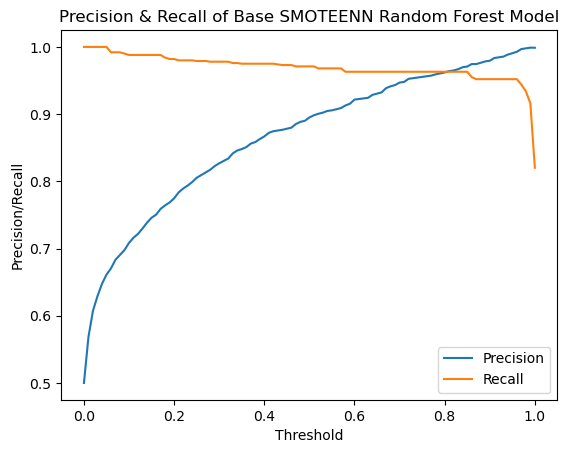

In [65]:
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.title('Precision & Recall of Base SMOTEENN Random Forest Model')
plt.show()

#### Hyperparameter Tuning SMOTEENN RF Model

In [68]:
# Create SMOTEENN object
smote_enn = SMOTEENN(random_state=42)

# Create Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define hyperparameter grid for Random Forest
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', None]
}

# Create a pipeline with SMOTEENN and Random Forest
pipeline_rf = Pipeline([
    ('smote_enn', smote_enn),   # Apply SMOTEENN for resampling
    ('rf', rf)                  # Random Forest model
])

# Setup GridSearchCV with the pipeline
grid_search_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model on the original training data
grid_search_rf.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search_rf.best_params_)

# Evaluate on the test data
best_rf_model = grid_search_rf.best_estimator_
test_accuracy_rf = best_rf_model.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy_rf:.4f}')

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'rf__max_depth': 30, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Test Accuracy: 0.9296


In [70]:
#fitting with best hyperparameters 
rf_smoteenn_tuned = RandomForestClassifier(random_state=42, 
                                         n_estimators=100, max_depth= 30, 
                                         max_features = 'sqrt', min_samples_leaf = 1,
                                         min_samples_split = 2
                                        )  
rf_smoteenn_tuned.fit(X_train_resampled_smote_enn, y_train_resampled_smote_enn)

RandomForestClassifier(max_depth=30, random_state=42)

In [72]:
#Predict on training set using the Random Forest model
y_prob_train_rf_smoteenn_tuned = rf_smoteenn_tuned.predict_proba(X_train)[:, 1]  # Get the predicted probabilities for training data
y_train_pred_custom_threshold_rf_smoteenn_tuned = (y_prob_train_rf_smoteenn_tuned >= .3).astype(int)


In [74]:
# Step 3: Predict on test set using the Random Forest model
y_prob_rf_smoteenn_tuned = rf_smoteenn_tuned.predict_proba(X_test)[:, 1]  # Get the predicted probabilities
y_pred_custom_threshold_rf_smoteenn_tuned = (y_prob_rf_smoteenn_tuned >= .3).astype(int)

In [76]:
# Step 4: Evaluate the Random Forest model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom_threshold_rf_smoteenn_tuned))
print("\nClassification Report with Threshold (0.3):\n", classification_report(y_test,y_pred_custom_threshold_rf_smoteenn_tuned))
print("\nAccuracy Score:\n", accuracy_score(y_test,y_pred_custom_threshold_rf_smoteenn_tuned))

Confusion Matrix:
 [[796 205]
 [ 22 979]]

Classification Report with Threshold (0.3):
               precision    recall  f1-score   support

           0       0.97      0.80      0.88      1001
           1       0.83      0.98      0.90      1001

    accuracy                           0.89      2002
   macro avg       0.90      0.89      0.89      2002
weighted avg       0.90      0.89      0.89      2002


Accuracy Score:
 0.8866133866133866


In [78]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_rf_smoteenn_tuned)

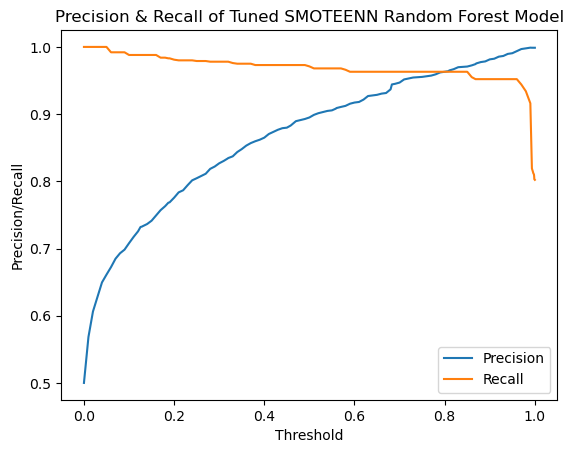

In [80]:
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.title('Precision & Recall of Tuned SMOTEENN Random Forest Model')
plt.show()

In [82]:
# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred_custom_threshold_rf_smoteenn_tuned)
test_accuracy = accuracy_score(y_test, y_pred_custom_threshold_rf_smoteenn_tuned)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9467
Test Accuracy: 0.8866


### Feature Importances

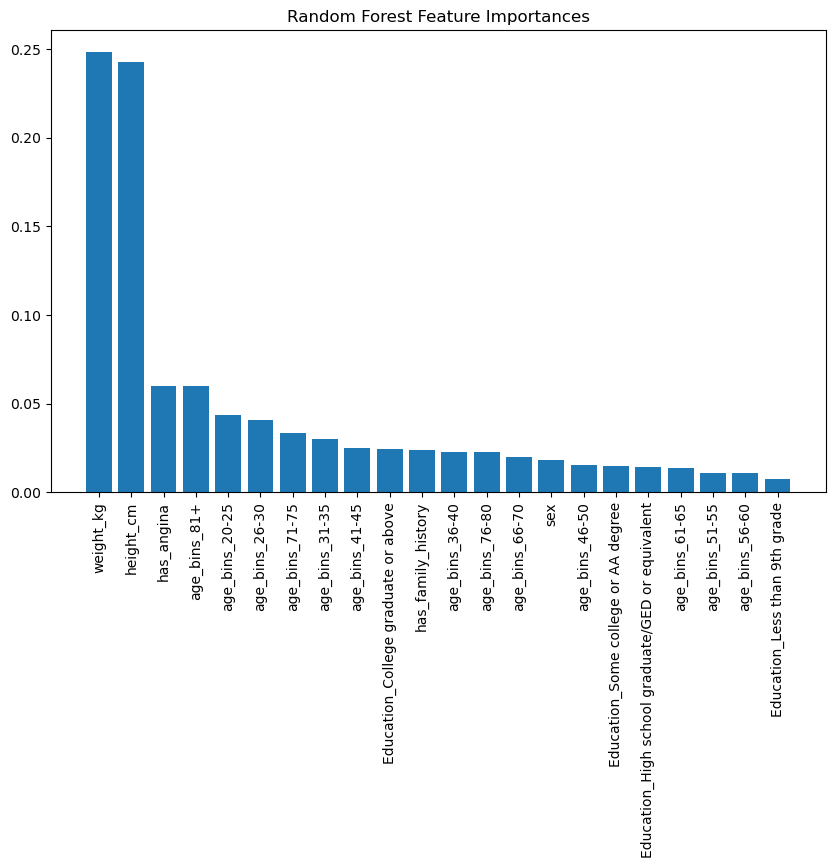

In [84]:
importances_rf = rf_smoteenn_tuned.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

# Plot feature importances
plt.figure(figsize=(10,6))
plt.title("Random Forest Feature Importances")
plt.bar(range(len(importances_rf)), importances_rf[indices_rf], align='center')
plt.xticks(range(len(importances_rf)), X_train.columns[indices_rf], rotation=90)
plt.show()

#### SHAP for RF Model

In [87]:
import shap 
shap.initjs()

In [88]:
X.columns

Index(['sex', 'age_bins_20-25', 'age_bins_26-30', 'age_bins_31-35',
       'age_bins_36-40', 'age_bins_41-45', 'age_bins_46-50', 'age_bins_51-55',
       'age_bins_56-60', 'age_bins_61-65', 'age_bins_66-70', 'age_bins_71-75',
       'age_bins_76-80', 'age_bins_81+', 'height_cm', 'weight_kg',
       'Education_College graduate or above',
       'Education_High school graduate/GED or equivalent',
       'Education_Less than 9th grade', 'Education_Some college or AA degree',
       'has_angina', 'has_family_history'],
      dtype='object')

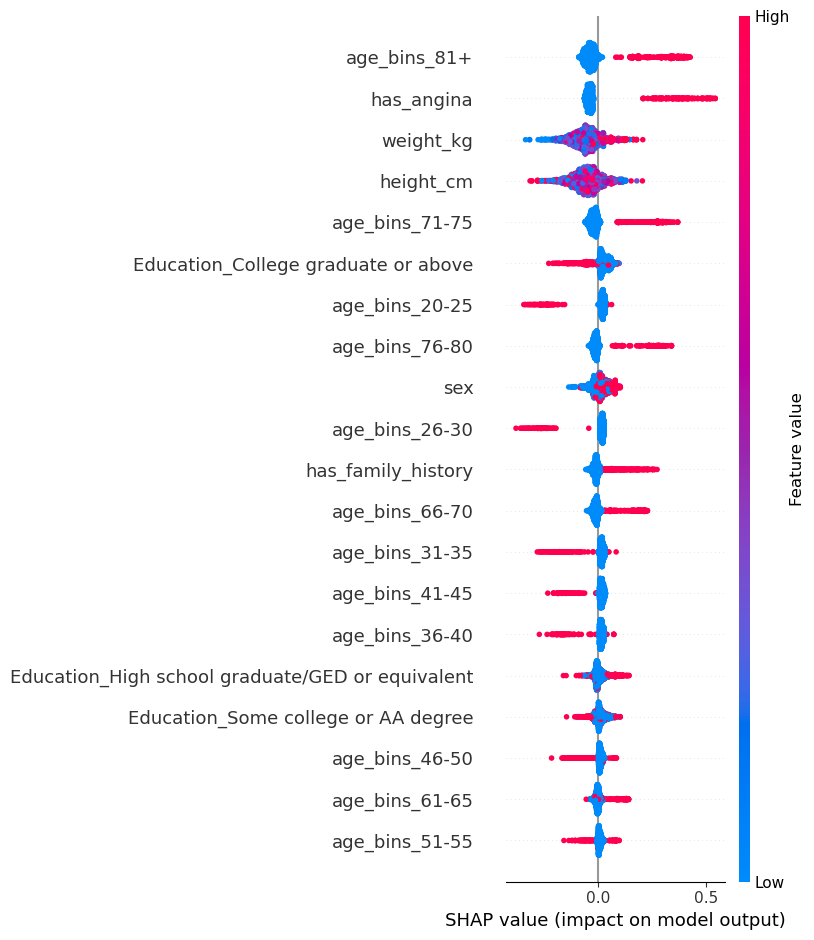

In [89]:
# shap summary plot

explainer = shap.TreeExplainer(rf_smoteenn_tuned)
shap_values = explainer(X_test)

#calculate SHAP values for test set
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[:,:,1], X_test)

## XGB Model with SMOTEENN & Class Weighting

In [277]:
# Create an XGBoost model instance
import xgboost as xgb

xgb_model_smote_enn = xgb.XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Handle class imbalance
    random_state=42,
    use_label_encoder=False,  # Disable warning for label encoding
    eval_metric='logloss'  # Set evaluation metric
)

# Fit the model on the resampled dataset
xgb_model_smote_enn.fit(X_train_resampled_smote_enn, y_train_resampled_smote_enn)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [279]:
# Predict on the test set 
y_prob_xgb_smote_enn = xgb_model_smote_enn.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
y_pred_custom_threshold_xgb_smote_enn = (y_prob_xgb_smote_enn >= 0.5).astype(int)  # Default threshold is 0.5, adjust if needed

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom_threshold_xgb_smote_enn))
print("\nClassification Report with Threshold (0.5):\n", classification_report(y_test, y_pred_custom_threshold_xgb_smote_enn))
print("\nAccuracy Score:\n", accuracy_score(y_test, y_pred_custom_threshold_xgb_smote_enn))

Confusion Matrix:
 [[767 235]
 [ 38  70]]

Classification Report with Threshold (0.5):
               precision    recall  f1-score   support

           0       0.95      0.77      0.85      1002
           1       0.23      0.65      0.34       108

    accuracy                           0.75      1110
   macro avg       0.59      0.71      0.59      1110
weighted avg       0.88      0.75      0.80      1110


Accuracy Score:
 0.754054054054054


In [281]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb_smote_enn)

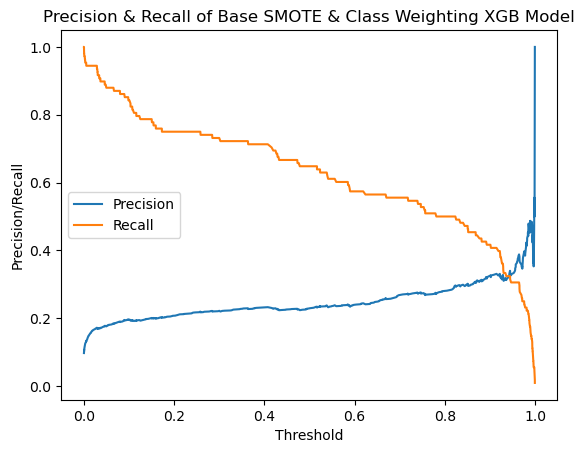

In [283]:
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.title('Precision & Recall of Base SMOTE & Class Weighting XGB Model')
plt.show()

### Tuning XGBoost Hyperparameters with SMOTEENN

In [286]:
# Create SMOTEENN object
smote_enn = SMOTEENN(random_state=42)

# Create XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define hyperparameter grid for XGBoost
param_grid_xgb = {
    'xgb__max_depth': [3, 5, 7],  # Note the xgb__ prefix
    'xgb__learning_rate': [0.1, 0.01, 0.001],
    'xgb__subsample': [0.5, 0.7, 1],
    'xgb__gamma': [0, 1, 10]
}

# Create a pipeline with SMOTE and XGBoost
pipeline_xgb = Pipeline([
    ('smote_enn', smote_enn),   # Apply SMOTEEN for resampling
    ('xgb', xgb_model)  # XGBoost model
])


# Setup GridSearchCV with the pipeline
grid_search_xgb = GridSearchCV(estimator=pipeline_xgb, param_grid=param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the model on the original training data
grid_search_xgb.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search_xgb.best_params_)

# Evaluate on the test data
best_xgb_model = grid_search_xgb.best_estimator_
test_accuracy_xgb = best_xgb_model.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy_xgb:.4f}')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters:  {'xgb__gamma': 1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__subsample': 0.7}
Test Accuracy: 0.8324


In [288]:
# using best hyperparameters, setting max_delta_step to 1 for imbalanced dataset, and using SMOTE
xgb_model_smoteenn_tuned = XGBClassifier(
 
    random_state=42,
     #scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    use_label_encoder=False,  # Disable warning for label encoding
    eval_metric='logloss',  # Set evaluation metric
    gamma=1,learning_rate=0.1, max_depth=7,subsample=0.7,max_delta_step=1) #best hyperparameters
xgb_model_smoteenn_tuned.fit(X_train_resampled_smote_enn, y_train_resampled_smote_enn)


 # Handle class imbalance # scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=1, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [292]:
y_train_pred = xgb_model_smoteenn_tuned.predict(X_train)
y_test_pred = xgb_model_smoteenn_tuned.predict(X_test)

In [294]:
# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.8693
Test Accuracy: 0.8306


In [296]:
# Predict on the test set 
y_prob_xgb_smoteenn_tuned = xgb_model_smoteenn_tuned.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
y_pred_custom_threshold_xgb_smoteenn_tuned = (y_prob_xgb_smoteenn_tuned >= 0.5).astype(int)  # Default threshold is 0.5, adjust if needed

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom_threshold_xgb_smoteenn_tuned))
print("\nClassification Report with Default Threshold (0.5):\n", classification_report(y_test, y_pred_custom_threshold_xgb_smoteenn_tuned))
print("\nAccuracy Score:\n", accuracy_score(y_test, y_pred_custom_threshold_xgb_smoteenn_tuned))

Confusion Matrix:
 [[859 143]
 [ 45  63]]

Classification Report with Default Threshold (0.5):
               precision    recall  f1-score   support

           0       0.95      0.86      0.90      1002
           1       0.31      0.58      0.40       108

    accuracy                           0.83      1110
   macro avg       0.63      0.72      0.65      1110
weighted avg       0.89      0.83      0.85      1110


Accuracy Score:
 0.8306306306306306


### Tuning Threshold

In [299]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb_smoteenn_tuned)

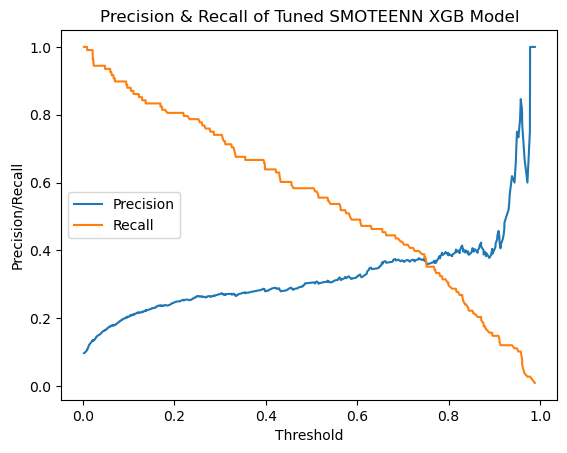

In [301]:
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.title('Precision & Recall of Tuned SMOTEENN XGB Model')
plt.show()

In [303]:
# Predict probabilities
y_prob_xgb_smoteenn_tuned = xgb_model_smoteenn_tuned.predict_proba(X_test)[:, 1]

# Adjust the threshold
y_pred_custom_threshold_xgb_smoteenn_tuned = (y_prob_xgb_smoteenn_tuned >= 0.25).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom_threshold_xgb_smoteenn_tuned))

# Evaluate with new threshold
print("\nClassification Report (Threshold 0.25):\n", classification_report(y_test, y_pred_custom_threshold_xgb_smoteenn_tuned))

Confusion Matrix:
 [[767 235]
 [ 23  85]]

Classification Report (Threshold 0.25):
               precision    recall  f1-score   support

           0       0.97      0.77      0.86      1002
           1       0.27      0.79      0.40       108

    accuracy                           0.77      1110
   macro avg       0.62      0.78      0.63      1110
weighted avg       0.90      0.77      0.81      1110



In [305]:
# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred_custom_threshold_xgb_smoteenn_tuned)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.8693
Test Accuracy: 0.7676


### Feature Importances

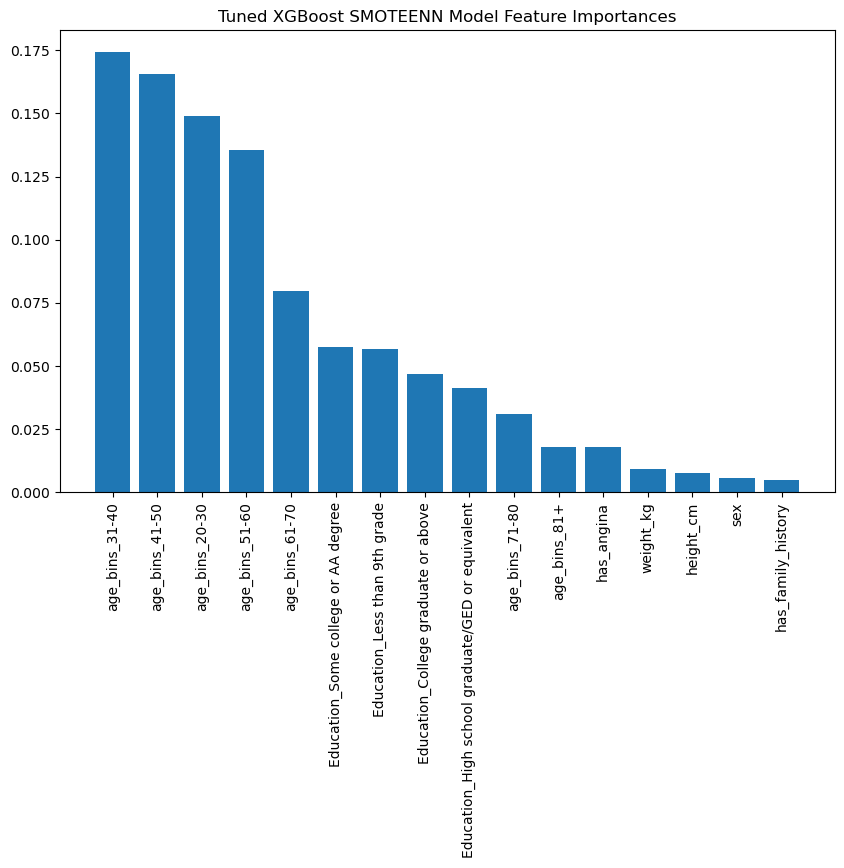

In [307]:
# Assuming xgb_model is your XGBoost model
importances_xgb_smoteenn = xgb_model_smoteenn_tuned.feature_importances_
indices_xgb = np.argsort(importances_xgb_smoteenn)[::-1]

# Plot feature importances
plt.figure(figsize=(10,6))
plt.title("Tuned XGBoost SMOTEENN Model Feature Importances")
plt.bar(range(len(importances_xgb_smoteenn)), importances_xgb_smoteenn[indices_xgb], align='center')
plt.xticks(range(len(importances_xgb_smoteenn)), X_train.columns[indices_xgb], rotation=90)
plt.show()

### Shap for XGB SMOTEENN Model

In [310]:
#computing shap values

#create shap explainer for RF model
explainer = shap.TreeExplainer(xgb_model_smoteenn_tuned)

#calculate SHAP values for test set
shap_values = explainer.shap_values(X_test)

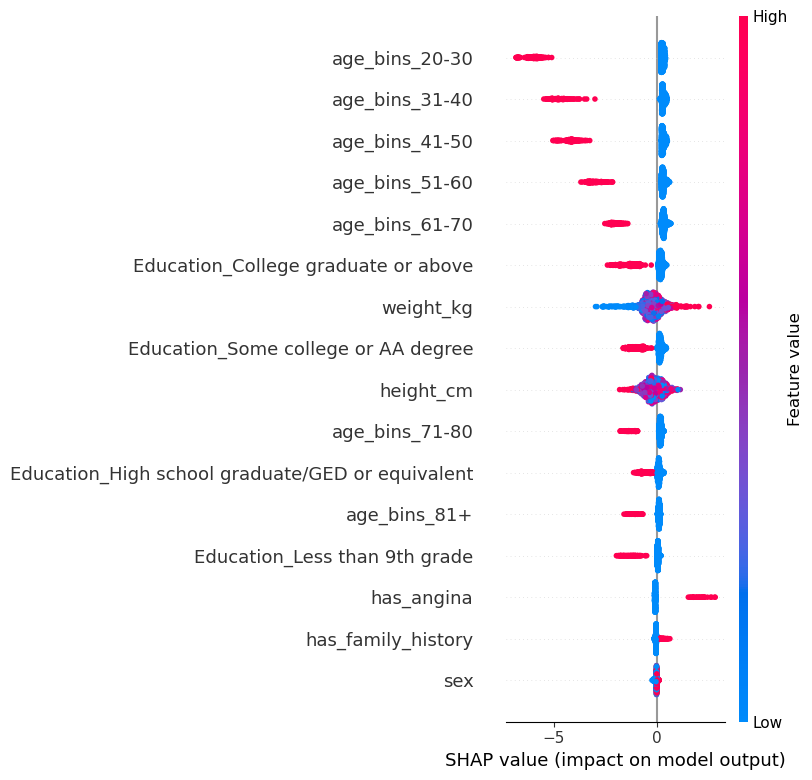

In [312]:
# shap summary plot
shap.summary_plot(shap_values[:,:], X_test)

In [314]:
Explainer = shap.Explainer(xgb_model_smoteenn_tuned, X_test)
shap_values = explainer(X_test)

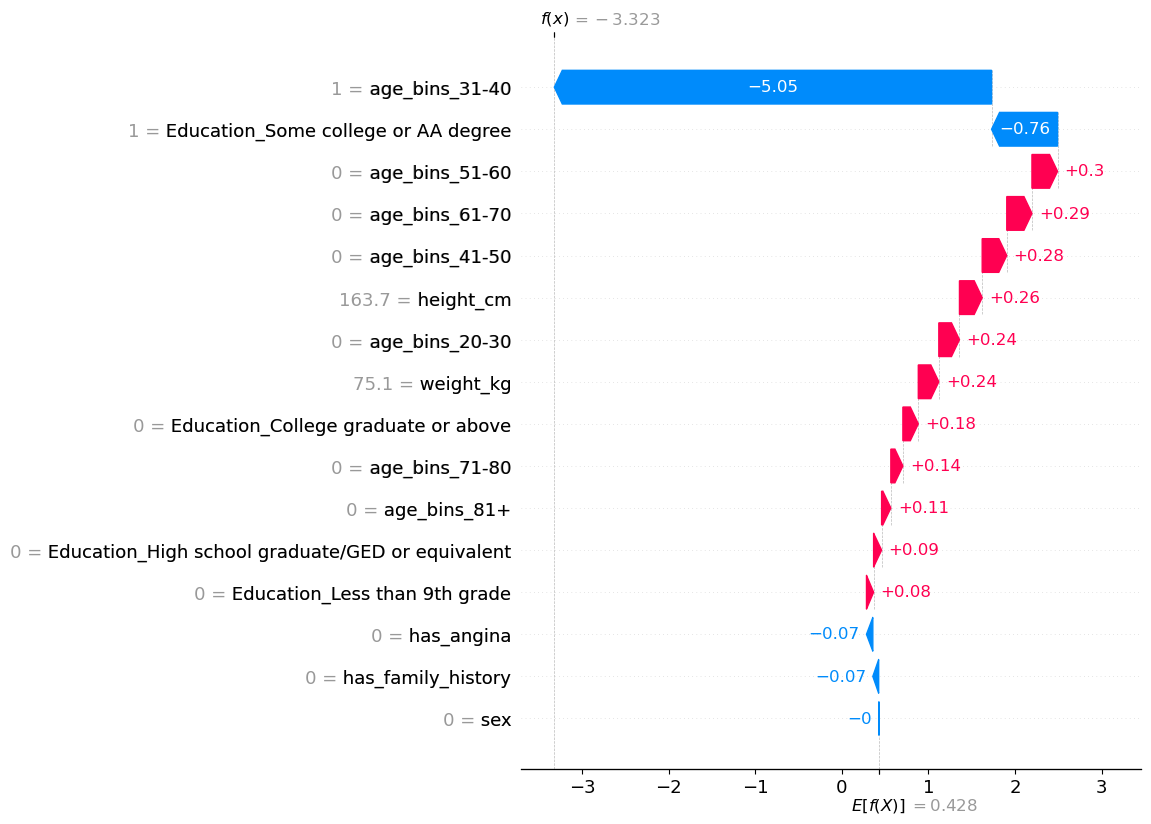

In [316]:
shap.plots.waterfall(shap_values[0], max_display=19)

In [318]:
y_prob_xgb_smoteenn_tuned  # Probabilities for the positive class


array([0.03478258, 0.02487044, 0.00656362, ..., 0.28752044, 0.5411693 ,
       0.13815501], dtype=float32)

In [320]:
# Define thresholds for high and low risk
high_risk_threshold = 0.9  # E.g., 90% probability for high risk
low_risk_threshold = 0.1   # E.g., 10% probability for low risk

# Identify indices of extreme cases
high_risk_indices = np.where(y_prob_xgb_smoteenn_tuned > high_risk_threshold)[0]
low_risk_indices = np.where(y_prob_xgb_smoteenn_tuned < low_risk_threshold)[0]

In [322]:
# Calculate SHAP values
explainer = shap.TreeExplainer(xgb_model_smoteenn_tuned)
shap_values = explainer.shap_values(X_test)

# Get SHAP values for extreme cases
shap_values_high_risk = shap_values[high_risk_indices]
shap_values_low_risk = shap_values[low_risk_indices]


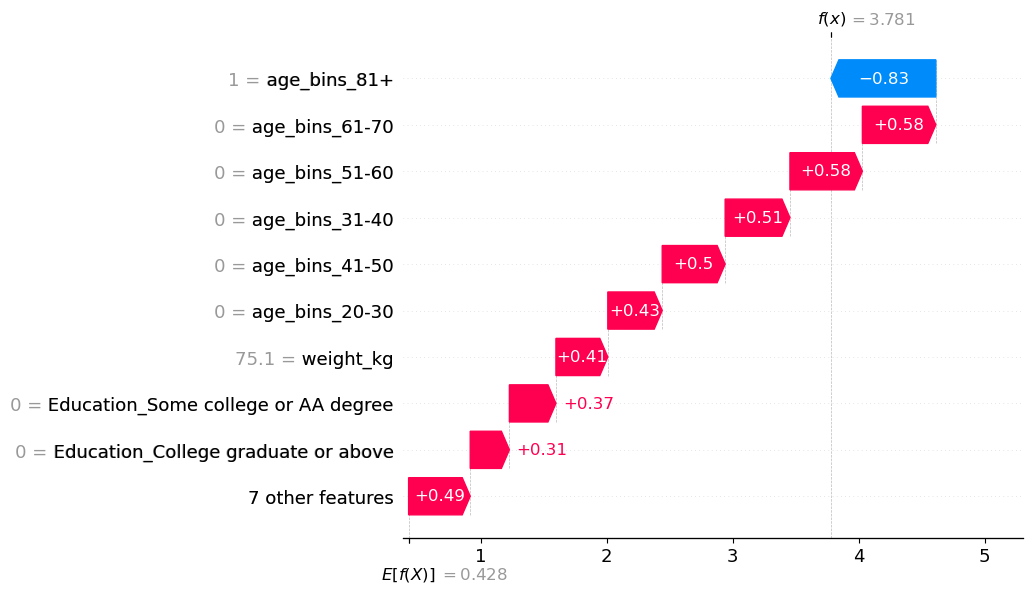

In [324]:
# Generate waterfall plots for high-risk cases
for i in high_risk_indices[:5]:  # Limit to first 5 for visualization purposes
     explanation = shap.Explanation(values=shap_values[i],
                                    base_values=explainer.expected_value,
                                    data=X_test.iloc[i],
                                    feature_names=X_test.columns)
shap.waterfall_plot(explanation)



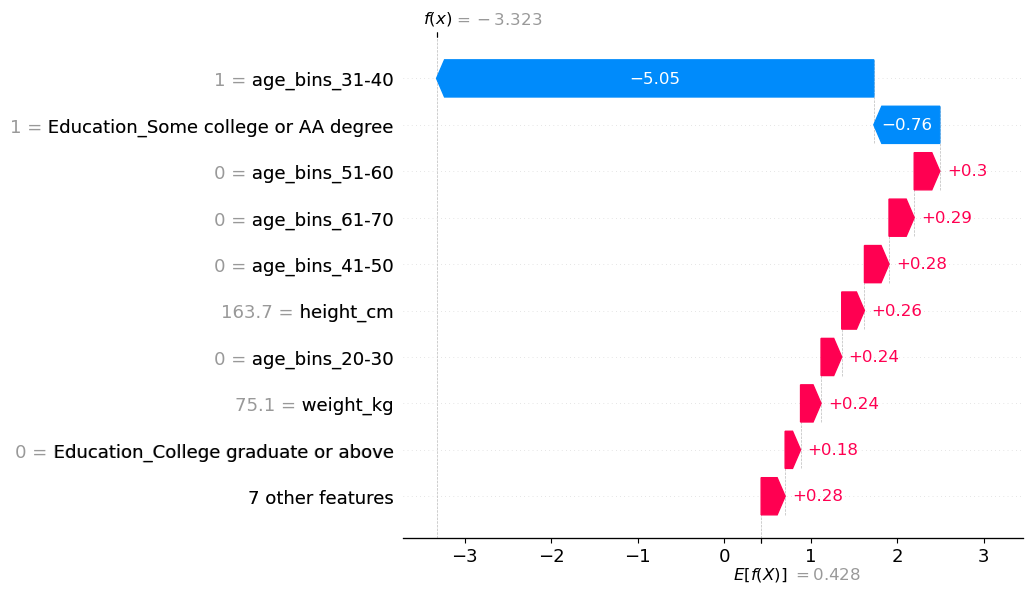

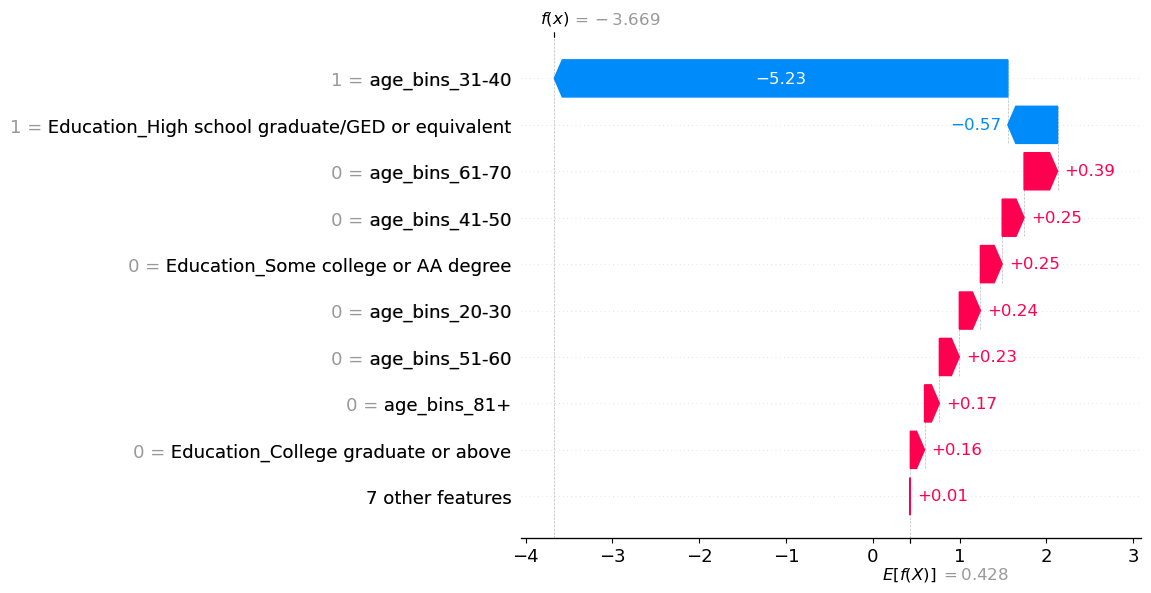

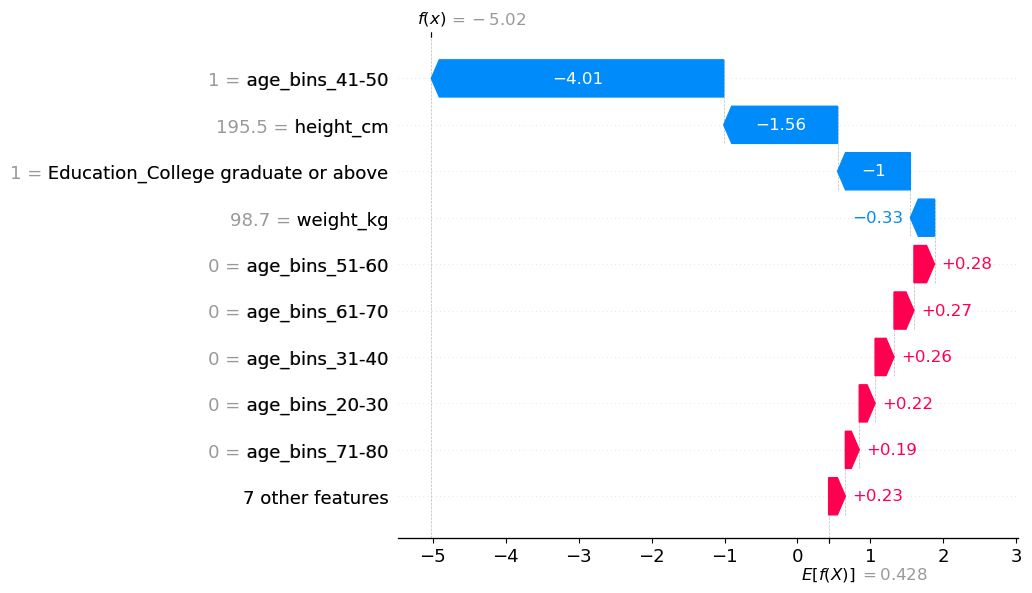

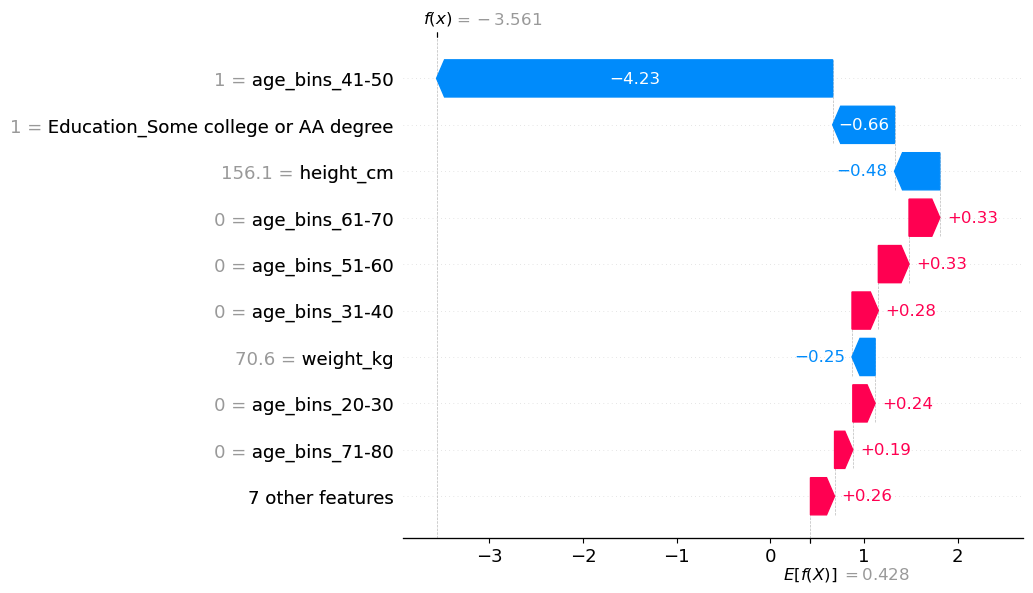

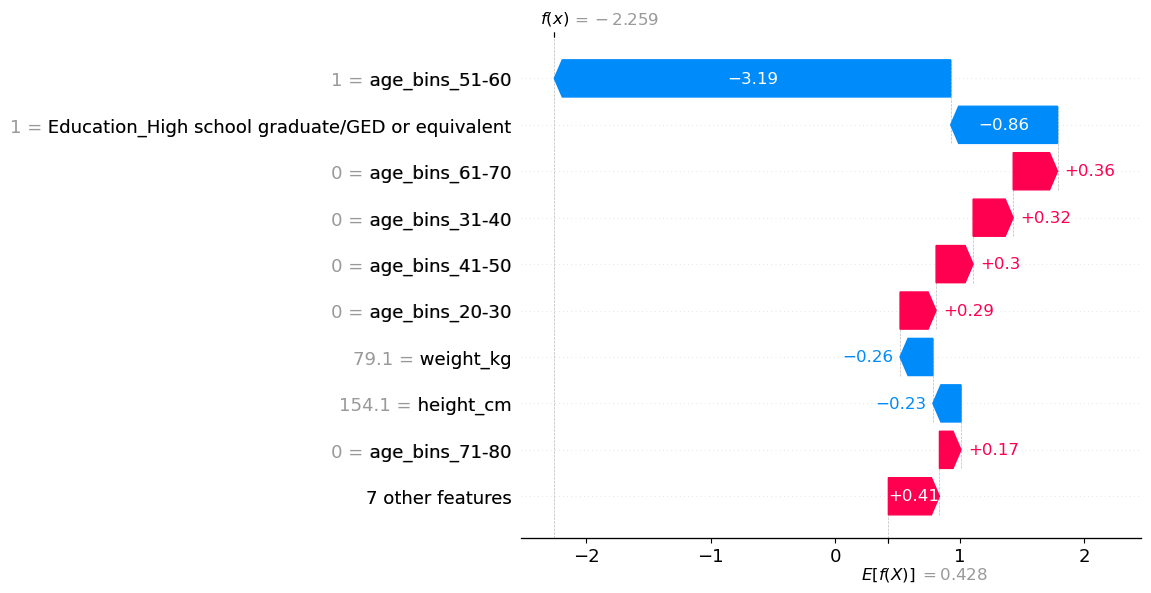

In [326]:
# Generate waterfall plots for low-risk cases
for i in low_risk_indices[:5]:  # Limit to first 5 for visualization purposes
    explanation = shap.Explanation(values=shap_values[i],
                                    base_values=explainer.expected_value,
                                    data=X_test.iloc[i],
                                    feature_names=X_test.columns)
    shap.waterfall_plot(explanation)


## Using ADASYN on XGB Model

In [329]:
from imblearn.over_sampling import ADASYN

In [331]:
# Perform ADASYN oversampling
adasyn = ADASYN(random_state=42)
X_train_resampled_adasyn, y_train_resampled_adasyn = adasyn.fit_resample(X_train, y_train)

# Train XGBoost with resampled data
xgb_adasyn = xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42)
xgb_adasyn.fit(X_train_resampled_adasyn, y_train_resampled_adasyn)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Evaluating without Threshold

In [334]:
# Evaluate
y_pred_adasyn = xgb_adasyn.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adasyn))
print("ADASYN - Classification Report:\n", classification_report(y_test, y_pred_adasyn))

Confusion Matrix:
 [[870 132]
 [ 53  55]]
ADASYN - Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90      1002
           1       0.29      0.51      0.37       108

    accuracy                           0.83      1110
   macro avg       0.62      0.69      0.64      1110
weighted avg       0.88      0.83      0.85      1110



### Evaluating with Threshold

In [337]:
# Predict probabilities
y_prob_xgb_adasyn= xgb_adasyn.predict_proba(X_test)[:, 1]

# Adjust the threshold
y_pred_custom_threshold_xgb_adasyn = (y_prob_xgb_adasyn >= 0.5).astype(int) #using default threshold

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom_threshold_xgb_adasyn))

# Evaluate with new threshold
print("\nClassification Report (Threshold 0.5):\n", classification_report(y_test, y_pred_custom_threshold_xgb_adasyn))

Confusion Matrix:
 [[870 132]
 [ 53  55]]

Classification Report (Threshold 0.5):
               precision    recall  f1-score   support

           0       0.94      0.87      0.90      1002
           1       0.29      0.51      0.37       108

    accuracy                           0.83      1110
   macro avg       0.62      0.69      0.64      1110
weighted avg       0.88      0.83      0.85      1110



### Using ADAYSYN on Tuned Hyperparameters XGB Model

In [340]:
from imblearn.pipeline import Pipeline

# Create ADASYN object
adasyn = ADASYN()

# Define the pipeline that applies ADASYN and then XGBoost
pipeline = Pipeline([
    ('adasyn', adasyn),  # Apply ADASYN resampling
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))  # XGBoost model
])

# Define the hyperparameter grid
param_grid = {
    'xgb__max_depth': [3, 5, 7],  # Note the 'xgb__' prefix for grid search
    'xgb__learning_rate': [0.1, 0.01, 0.001],
    'xgb__subsample': [0.5, 0.7, 1],
    'xgb__gamma': [0, 1, 10]
}

# Create GridSearchCV object
grid_search_xgb = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fitting GridSearchCV on the original (unresampled) training data
grid_search_xgb.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search_xgb.best_params_)

# Get the best model
best_xgb_model = grid_search_xgb.best_estimator_

# Evaluate the best model on the test set
test_accuracy = best_xgb_model.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

Best parameters:  {'xgb__gamma': 1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__subsample': 0.5}
Test Accuracy: 0.8856


In [344]:
# using best hyperparameters, setting max_delta_step to 1 for imbalanced dataset, and using SMOTE
xgb_model_adasyn_tuned = XGBClassifier(
    random_state=42,
     #scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    use_label_encoder=False,  # Disable warning for label encoding
    eval_metric='logloss',  # Set evaluation metric
    gamma=0,learning_rate=0.1, max_depth=7,subsample=0.5,max_delta_step=1) #best hyperparameters

xgb_model_adasyn_tuned.fit(X_train_resampled_adasyn, y_train_resampled_adasyn)

 # Handle class imbalance # scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=1, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [346]:
y_train_pred = xgb_model_adasyn_tuned.predict(X_train)
y_test_pred = xgb_model_adasyn_tuned.predict(X_test)

In [348]:
# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9249
Test Accuracy: 0.8766


### Tuning Threshold with Tuned XGB ADASYN Model

In [351]:
# Predict on the test set 
y_prob_xgb_adasyn_tuned = xgb_model_adasyn_tuned.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
y_pred_custom_threshold_xgb_adasyn_tuned = (y_prob_xgb_adasyn_tuned >= 0.25).astype(int)  # Default threshold is 0.5, adjust if needed

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom_threshold_xgb_adasyn_tuned))
print("\nClassification Report with Threshold (0.25):\n", classification_report(y_test, y_pred_custom_threshold_xgb_adasyn_tuned))
print("\nAccuracy Score:\n", accuracy_score(y_test, y_pred_custom_threshold_xgb_adasyn_tuned))

Confusion Matrix:
 [[859 143]
 [ 42  66]]

Classification Report with Threshold (0.25):
               precision    recall  f1-score   support

           0       0.95      0.86      0.90      1002
           1       0.32      0.61      0.42       108

    accuracy                           0.83      1110
   macro avg       0.63      0.73      0.66      1110
weighted avg       0.89      0.83      0.86      1110


Accuracy Score:
 0.8333333333333334


In [353]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb_adasyn_tuned)

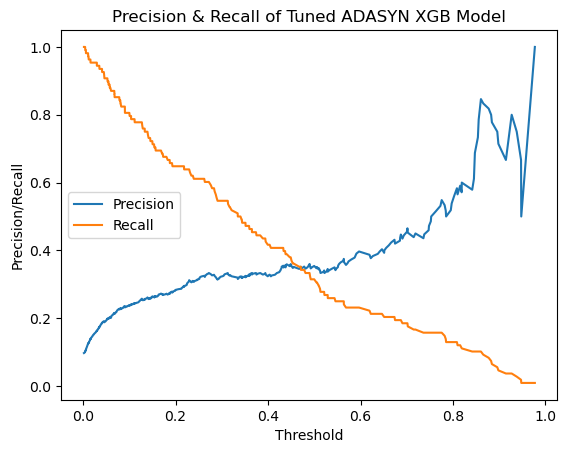

In [355]:
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.title('Precision & Recall of Tuned ADASYN XGB Model')
plt.show()

#### Feature Importances

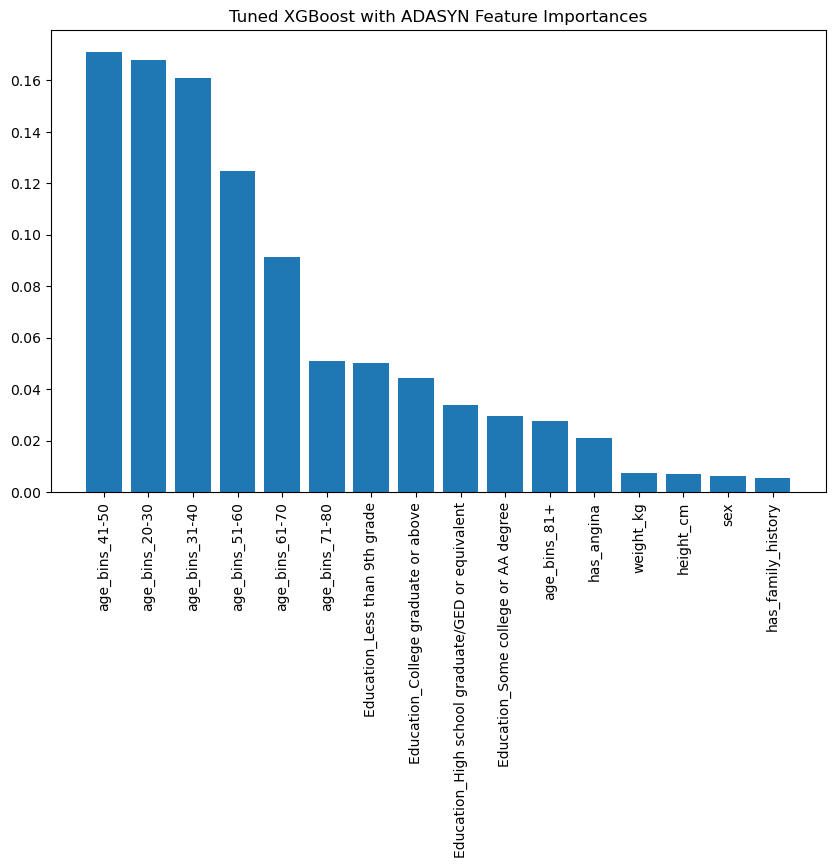

In [358]:
# Assuming xgb_model is your XGBoost model
importances_xgb_adasyn = xgb_model_adasyn_tuned.feature_importances_
indices_xgb = np.argsort(importances_xgb_adasyn)[::-1]

# Plot feature importances
plt.figure(figsize=(10,6))
plt.title("Tuned XGBoost with ADASYN Feature Importances")
plt.bar(range(len(importances_xgb_adasyn)), importances_xgb_adasyn[indices_xgb], align='center')
plt.xticks(range(len(importances_xgb_adasyn)), X_train.columns[indices_xgb], rotation=90)
plt.show()

In [360]:
#computing shap values

#create shap explainer for RF model
explainer = shap.TreeExplainer(xgb_model_adasyn_tuned, X_test)

#calculate SHAP values for test set
shap_values = explainer.shap_values(X_test)

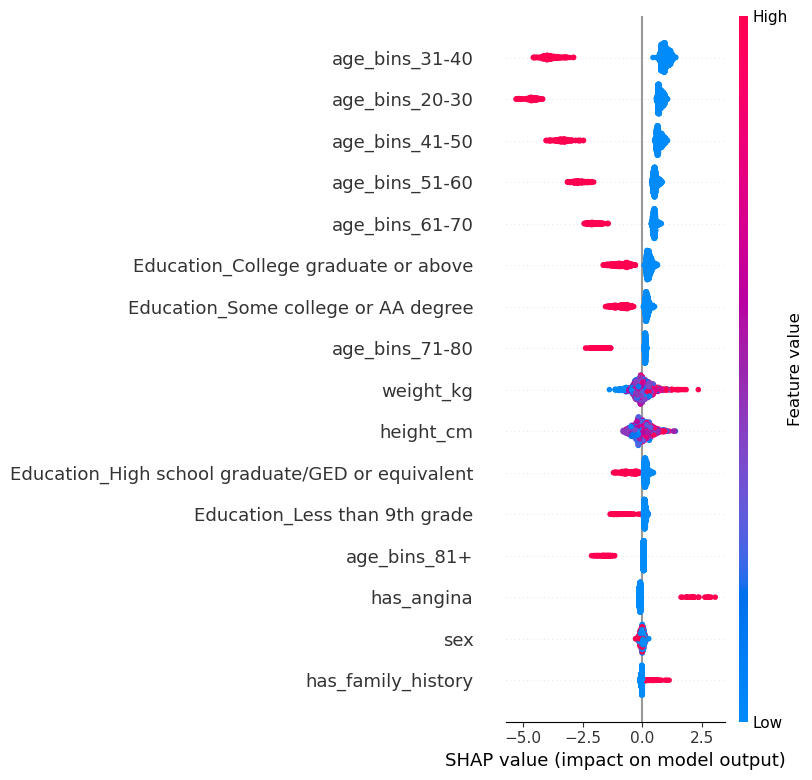

In [361]:
# shap summary plot
shap.summary_plot(shap_values[:,:], X_test)

## Blending RF, XGB with SMOTEENN and XGB with ADASYN Models

### Simple Averaging of Predictions Approach 

In [366]:
# getting predictions from each model 
# Step 1: Get predicted probabilities from both models on the test set
y_prob_rf_smoteenn_tuned = rf_smoteenn_tuned.predict_proba(X_test)[:, 1]  # Probabilities for Random Forest
y_prob_xgb_smoteenn_tuned = xgb_model_smoteenn_tuned.predict_proba(X_test)[:, 1]  # Probabilities for XGBoost (SMOTEENN)
y_prob_xgb_adasyn_tuned = xgb_model_adasyn_tuned.predict_proba(X_test)[:, 1]  # Probabilities for XGBoost (ADASYN)

In [368]:
# Step 2: Average the probabilities (soft voting)
y_prob_blended = (y_prob_rf_smoteenn_tuned + y_prob_xgb_smoteenn_tuned + y_prob_xgb_adasyn_tuned) / 3

In [370]:
# Step 3: Convert probabilities to binary predictions using a threshold (0.5 by default, can be adjusted)
threshold = 0.2
y_pred_blended = (y_prob_blended >= threshold).astype(int)

In [372]:
# Step 4: Evaluate the blended model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_blended))
print("\nClassification Report with Threshold (0.2):\n", classification_report(y_test, y_pred_blended))
print("\nAccuracy Score:\n", accuracy_score(y_test, y_pred_blended))

Confusion Matrix:
 [[745 257]
 [ 20  88]]

Classification Report with Threshold (0.2):
               precision    recall  f1-score   support

           0       0.97      0.74      0.84      1002
           1       0.26      0.81      0.39       108

    accuracy                           0.75      1110
   macro avg       0.61      0.78      0.62      1110
weighted avg       0.90      0.75      0.80      1110


Accuracy Score:
 0.7504504504504504


In [374]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_blended)

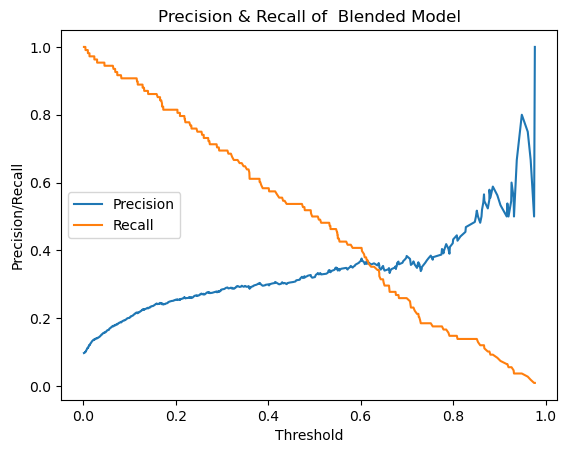

In [376]:
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.title('Precision & Recall of  Blended Model')
plt.show()

### Threshold Tuning 

In [379]:
threshold = 0.30
y_pred_blended = (y_prob_blended >= threshold).astype(int)

In [381]:
# Step 4: Evaluate the blended model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_blended))
print("\nClassification Report with Threshold (0.30):\n", classification_report(y_test, y_pred_blended))
print("\nAccuracy Score:\n", accuracy_score(y_test, y_pred_blended))

Confusion Matrix:
 [[814 188]
 [ 33  75]]

Classification Report with Threshold (0.30):
               precision    recall  f1-score   support

           0       0.96      0.81      0.88      1002
           1       0.29      0.69      0.40       108

    accuracy                           0.80      1110
   macro avg       0.62      0.75      0.64      1110
weighted avg       0.90      0.80      0.83      1110


Accuracy Score:
 0.8009009009009009


#### Feature Importances

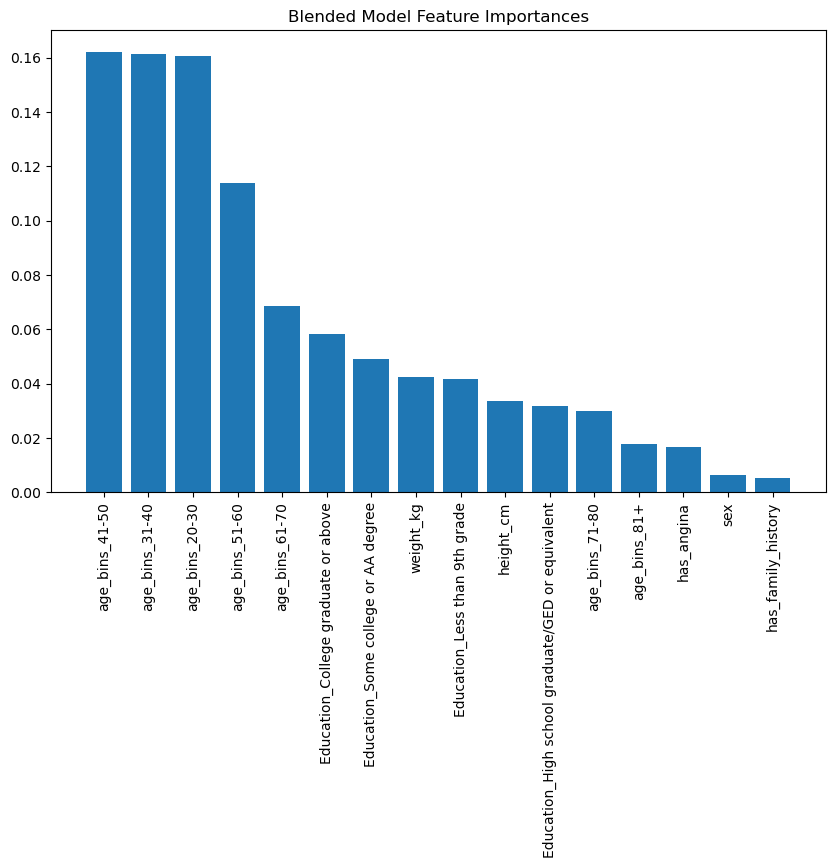

In [384]:
# Average feature importances from multiple models
combined_importances = (importances_rf + importances_xgb_smoteenn + importances_xgb_adasyn) / 3
indices_combined = np.argsort(combined_importances)[::-1]

# Plot combined feature importances
plt.figure(figsize=(10,6))
plt.title("Blended Model Feature Importances")
plt.bar(range(len(combined_importances)), combined_importances[indices_combined], align='center')
plt.xticks(range(len(combined_importances)), X_train.columns[indices_combined], rotation=90)
plt.show()

## Deploying Best Model

In [95]:
import joblib

In [99]:
# Save each individual model
joblib.dump(rf_smoteenn_tuned, 'rf_smoteenn_tuned.pkl')
#joblib.dump(xgb_model_smoteenn_tuned, 'xgb_model_smoteenn_tuned.pkl')
#joblib.dump(xgb_model_adasyn_tuned, 'xgb_model_adasyn_tuned.pkl')

['rf_smoteenn_tuned.pkl']

In [390]:
# Save blending logic as a function or class
def blended_model_predict(X):
    y_prob_rf = rf_smoteenn_tuned.predict_proba(X)[:, 1]
    y_prob_xgb_smoteenn = xgb_model_smoteenn_tuned.predict_proba(X)[:, 1]
    y_prob_xgb_adasyn = xgb_model_adasyn_tuned.predict_proba(X)[:, 1]
    
    # Average probabilities
    y_prob_blended = (y_prob_rf + y_prob_xgb_smoteenn + y_prob_xgb_adasyn) / 3
    return y_prob_blended

In [392]:
joblib.dump(blended_model_predict, 'blended_model_predict.pkl')

['blended_model_predict.pkl']